In [1]:
# first to run everytime
# %config InlineBackend.figure_format = 'retina'
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from astropy.io import ascii
import os

### Contour plot function

In [2]:
def CDF_contour(linename, objname, fitting_table,
                plot=True, cont=False, pix_cen=None, output=None, print_obj=False,
                sigma_floor=0, nofits=False, ggd37=False, debug=False, offset=True):

    from scipy.interpolate import griddata, LinearNDInterpolator
    from mpl_toolkits.axes_grid1 import make_axes_locatable
    from astropy.io import ascii, fits
    import numpy as np
    import matplotlib.pyplot as plt

    # get the line data
    fitting = ascii.read(fitting_table)
    data = fitting[(fitting['Object'] == objname) & (fitting['Line'] == linename) & (fitting['Pixel_No.'] != 'c')]

    # determine the name of the central spaxel
    if pix_cen == None:
        if not ggd37:
            pix_cen_list = ['SLWC3', 'SSWD4','13']
            pix_cen = data['Pixel_No.'][(data['Pixel_No.'] == pix_cen_list[0])+\
                                        (data['Pixel_No.'] == pix_cen_list[1])+\
                                        (data['Pixel_No.'] == pix_cen_list[2])]
        else:
            # choose the smallest pixel number found in the list
            pix_cen = data['Pixel_No.'][data['Line'] == linename].min()
    
    if debug:
        return data, pix_cen
    
    if offset:
        # get the RA & Dec of the central spaxel
        ra_cen = data['RA(deg)'][data['Pixel_No.'] == pix_cen].data
        dec_cen = data['Dec(deg)'][data['Pixel_No.'] == pix_cen].data
        # calculate the RA and Dec separations
        plot_ra = (data['RA(deg)'].data-ra_cen)*np.cos(np.radians(dec_cen))*3600
        plot_dec = (data['Dec(deg)'].data-dec_cen)*3600
    else:
        plot_ra = data['RA(deg)'].data
        plot_dec = data['Dec(deg)'].data
    
    # create a list of both plot_ra and plot_dec
    coords = list(zip(plot_ra, plot_dec))
    
    # determine the size of the contour plot
    size = np.ceil(max(abs(plot_ra).max(), abs(plot_dec).max())/10)*10
    
    # round up the ranges of RA and Dec separations, and calculate the number of points in between
    ra_range = [np.ceil(abs(plot_ra.max())/10)*np.sign(plot_ra.max())*10,
                np.ceil(abs(plot_ra.min())/10)*np.sign(plot_ra.min())*10,
                np.ceil((plot_ra.max()-plot_ra.min())/10)*10]
    dec_range = [np.ceil(abs(plot_dec.max())/10)*np.sign(plot_dec.max())*10,
                 np.ceil(abs(plot_dec.min())/10)*np.sign(plot_dec.min())*10,
                 np.ceil((plot_dec.max()-plot_dec.min())/10)*10]
    
    # create the rebinned grid for RA and Dec.  Use oversample of 4.
    ra_rebin = np.linspace(ra_range[0], ra_range[1], ra_range[2]*4)
    dec_rebin = np.linspace(dec_range[1], dec_range[0], dec_range[2]*4)
    # a meshgrid for interpolation later
    ra, dec = np.meshgrid(ra_rebin, dec_rebin)

#     interp = LinearNDInterpolator(coords, data['Str(W/cm2)'].data, fill_value=np.nan)
#     z = interp(ra, dec)
#     z_cont = z
    
    z = griddata((plot_ra, plot_dec), data['Str(W/cm2)'].data, (ra_rebin[None,:], dec_rebin[:,None]), method='cubic')
    z_cont = griddata((plot_ra, plot_dec), data['Base(W/cm2/um)'].data*data['FWHM(um)'].data*1.086, 
                      (ra_rebin[None,:], dec_rebin[:,None]), method='cubic')
    
    # calculate the noise floor for the line emission
    sigma = np.nanmin(data['Str(W/cm2)']/data['SNR'].data)
    if sigma_floor != 0:
        z_floor = sigma*sigma_floor
    else:
        z_floor = np.nanmin(z)

    # create the figure and axis objects
    fig = plt.figure()
    ax = fig.add_subplot(111)

    # plot the contour with color and lines
    levels = np.linspace(z_floor, np.nanmax(z), 10)[1:]
    # define the levels with the actual range in the data not the interpolated grid
#     levels = np.linspace(z_floor, np.nanmax(data['Str(W/cm2)'].data), 10)[1:]
    ax.contour(ra_rebin, dec_rebin, z, levels, linewidths=1.5)
    
    # whether show the continuum as image or line emission as image
    if cont:
        im = ax.imshow(z_cont, cmap='Blues', origin='lower',
                       extent=[ra_range[0], ra_range[1],dec_range[1],dec_range[0]])
        im_label = 'F_{cont.}'
    else:
        im = ax.imshow(z, cmap='Blues', origin='lower', extent=[ra_range[0], ra_range[1],dec_range[1],dec_range[0]])
        im_label = 'F_{line}'
    
    # set the bad pixel to white
    im.cmap.set_bad('w', 1.)
    # setup ticks and tick labels
    ax.set_xticks(np.linspace(-np.ceil(-ra_range[1]/10)*10, np.ceil(ra_range[0]/10)*10, 5, dtype='int'))
    ax.set_xticklabels(np.linspace(-np.ceil(-ra_range[1]/10)*10, np.ceil(ra_range[0]/10)*10, 5, dtype='int'))
    ax.set_yticks(np.linspace(-np.ceil(-dec_range[1]/10)*10 , np.ceil(dec_range[0]/10)*10 , 5, dtype='int'))
    ax.set_yticklabels(np.linspace(-np.ceil(-dec_range[1]/10)*10, np.ceil(dec_range[0]/10)*10, 5, dtype='int'))

    # create the colorbar
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    cb = fig.colorbar(im, cax=cax)
    cb.solids.set_edgecolor("face")
    cb.ax.minorticks_on()
    cb.ax.set_ylabel(r'$\rm'+im_label+'\,[W\,cm^{-2}]$',fontsize=16)
    cb_obj = plt.getp(cb.ax.axes, 'yticklabels')
    plt.setp(cb_obj,fontsize=12)

    # set the x, y labels
    ax.set_xlabel(r'$\rm{RA\,offset\,[arcsec]}$', fontsize=18)
    ax.set_ylabel(r'$\rm{Dec\,offset\,[arcsec]}$', fontsize=18)
    [ax.spines[axis].set_linewidth(1.5) for axis in ['top','bottom','left','right']]
    ax.minorticks_on()
    ax.tick_params('both',labelsize=14,width=1.5,which='major',pad=5,length=5)
    ax.tick_params('both',labelsize=14,width=1.5,which='minor',pad=5,length=2.5)
    ax.set_aspect('equal', 'datalim')
    
    # print the object name
    if print_obj:
        ax.text(0.9, 0.9, objname, transform=ax.transAxes, fontsize=18, ha='right')
    
    # output the interpolated 2D array and the RA/Dec arrays into FITS and ASCII files
    if output != None:
        if not nofits:
            hdulist = fits.HDUList([fits.PrimaryHDU(z), fits.ImageHDU(z_cont)])
            hdulist.writeto(output, overwrite=True)
        
        # write out the RA/Dec arrays
        foo = open(output.split('.')[0]+'_interpolated_RA.txt', 'w')
        # the coordinates of the reference pixel
        foo.write('# Pixel 1: {:<12.8f} / {:<12.8f}\n'.format(ra_cen[0], dec_cen[0]))
        foo.write('{:<12s}\n'.format('RA_offset'))
        for i, ra_dum in enumerate(ra_rebin):
            foo.write('{:<12.8f}\n'.format(ra_dum))
        foo.close()
        
        foo = open(output.split('.')[0]+'_interpolated_Dec.txt', 'w')
        # the coordinates of the reference pixel
        foo.write('# Pixel 1: {:<12.8f} / {:<12.8f}\n'.format(ra_cen[0], dec_cen[0]))
        foo.write('{:<12s}\n'.format('Dec_offset'))
        for i, dec_dum in enumerate(dec_rebin):
            foo.write('{:<12.8f}\n'.format(dec_dum))
        foo.close()
        
        fig.savefig(output.split('.')[0]+'_contour.pdf', format='pdf', dpi=300, bbox_inches='tight')
        print('Figure saved at ', output.split('.')[0]+'_contour.pdf')
    
    return (ra_rebin, dec_rebin), (z, z_cont)

### LH

In [7]:
# LH
# stitch all fitting tables for each pixel into a single table
indir = '/Users/yaolun/test/ggd37_fitting/'
max_pixel = 300
foo = open(indir+'LH/ggd37_irs_LH_lines.txt', 'w')
for i in range(1,max_pixel+1):
    foo_dum = open(indir+'LH/ggd37_irs_pixel'+str(i)+'_lines.txt', 'r').readlines()
    if i == 1:
        foo.write('{:>12s}  '.format('Object')+foo_dum[0][:-1]+'  {:>12s}\n'.format('Pixel_No.'))
    for line in foo_dum[1:]:
        foo.write('{:>12s}  '.format('GGD37')+line[:-1]+'  {:>12d}\n'.format(i))

foo.close()

### SH

In [ ]:
# SH
# stitch all fitting tables for each pixel into a single table
indir = '/Users/yaolun/test/ggd37_fitting/'
max_pixel = 1260
foo = open(indir+'SH/ggd37_irs_SH_lines.txt', 'w')
for i in range(1,max_pixel+1):
    foo_dum = open(indir+'SH/ggd37_irs_pixel'+str(i)+'_lines.txt', 'r').readlines()
    if i == 1:
        foo.write('{:>12s}  '.format('Object')+foo_dum[0][:-1]+'  {:>12s}\n'.format('Pixel_No.'))
    for line in foo_dum[1:]:
        foo.write('{:>12s}  '.format('GGD37')+line[:-1]+'  {:>12d}\n'.format(i))

foo.close()

Plot SH and LH modules

['SIII33', 'SI25', 'FeII35', 'SiII34', 'FeII24', 'NeIII36', 'FeII26', 'FeIII23', 'H2S0']
processing  SIII33
-7.05599749865 109.874372532
-50.0184 19.8432


/Users/yaolun/anaconda/lib/python3.5/site-packages/astropy/table/column.py:267: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return self.data.__ne__(other)
/Users/yaolun/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:56: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
/Users/yaolun/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:57: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.


Figure saved at  /Users/yaolun/test/ggd37_fitting/LH/SIII33_contour.pdf
processing  SI25
-7.05599749865 109.874372532
-50.0184 19.8432
Figure saved at  /Users/yaolun/test/ggd37_fitting/LH/SI25_contour.pdf
processing  FeII35
-7.05599749865 109.874372532
-50.0184 19.8432
Figure saved at  /Users/yaolun/test/ggd37_fitting/LH/FeII35_contour.pdf
processing  SiII34
-7.05599749865 109.874372532
-50.0184 19.8432
Figure saved at  /Users/yaolun/test/ggd37_fitting/LH/SiII34_contour.pdf
processing  FeII24
-7.05599749865 109.874372532
-50.0184 19.8432
Figure saved at  /Users/yaolun/test/ggd37_fitting/LH/FeII24_contour.pdf
processing  NeIII36
-7.05599749865 109.874372532
-50.0184 19.8432
Figure saved at  /Users/yaolun/test/ggd37_fitting/LH/NeIII36_contour.pdf
processing  FeII26
-7.05599749865 109.874372532
-50.0184 19.8432
Figure saved at  /Users/yaolun/test/ggd37_fitting/LH/FeII26_contour.pdf
processing  FeIII23
-7.05599749865 109.874372532
-50.0184 19.8432
Figure saved at  /Users/yaolun/test/ggd37_

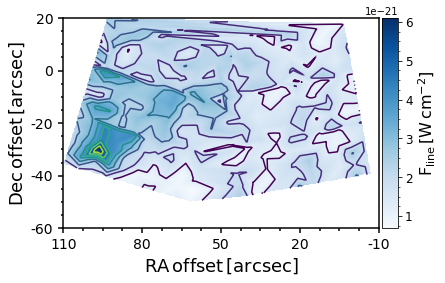

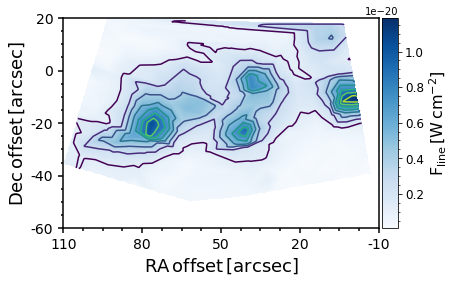

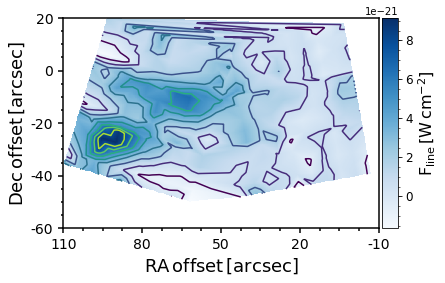

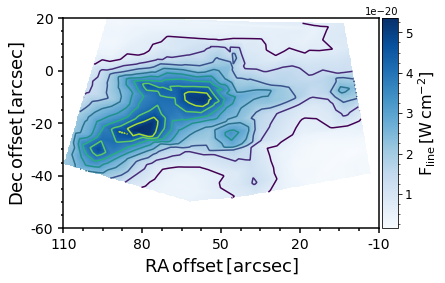

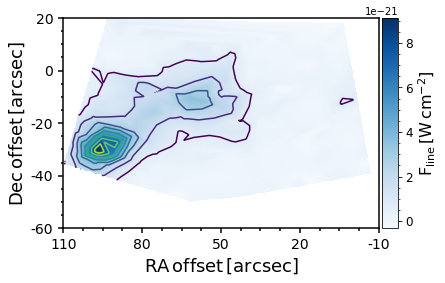

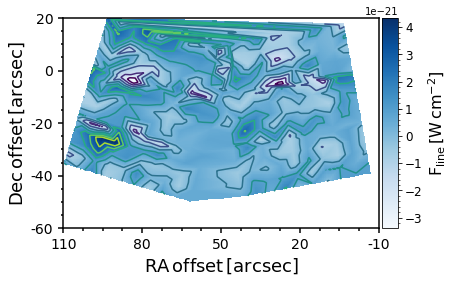

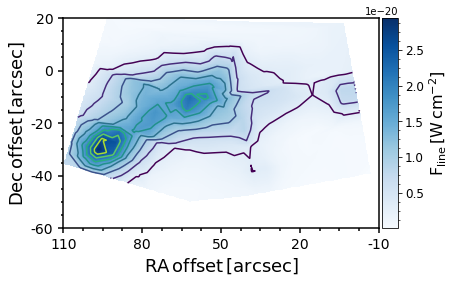

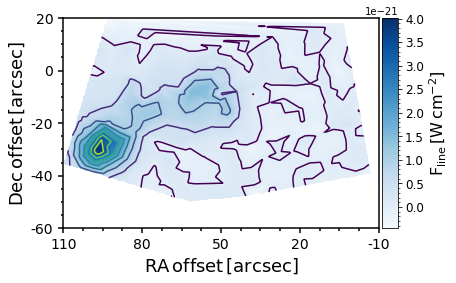

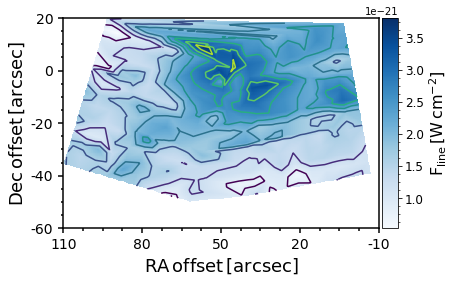

In [8]:
# get line list from the fitting table
modules = ['SH', 'LH']
modules = ['LH']
indir = '/Users/yaolun/test/ggd37_fitting/'
for m in modules:
#     print(indir+m+'/ggd37_irs_'+m+'_lines.txt')
    linelist = list(set(ascii.read(indir+m+'/ggd37_irs_'+m+'_lines.txt')['Line']))
    print(linelist)

    for line in linelist:
        print('processing ', line)
        coord_rebin, z_list = CDF_contour(line, 'GGD37',
                                          indir+m+'/ggd37_irs_'+m+'_lines.txt',
                                          pix_cen=1, cont=False,
                                          output=indir+m+'/'+line+'.fits', nofits=True,
                                          ggd37=True)

### SL

In [ ]:
# SL
# stitch all fitting tables for each pixel into a single table
indir = '/Users/yaolun/test/ggd37_fitting/'
max_pixel = 6448
foo = open(indir+'SL/ggd37_irs_SL_lines.txt', 'w')
for i in range(1,max_pixel+1):
    foo_dum = open(indir+'SL/ggd37_irs_pixel'+str(i)+'_lines.txt', 'r').readlines()
    if i == 1:
        foo.write('{:>12s}  '.format('Object')+foo_dum[0][:-1]+'  {:>12s}\n'.format('Pixel_No.'))
    for line in foo_dum[1:]:
        foo.write('{:>12s}  '.format('GGD37')+line[:-1]+'  {:>12d}\n'.format(i))

foo.close()

### plot contours for SL module

In [ ]:
# get line list from the fitting table
modules = ['SL']
indir = '/Users/yaolun/test/ggd37_fitting/'
for m in modules:
#     print(indir+m+'/ggd37_irs_'+m+'_lines.txt')
    linelist = list(set(ascii.read(indir+m+'/ggd37_irs_'+m+'_lines.txt')['Line']))
    print(linelist)

    for line in linelist:
        print('processing ', line)
        if line != 'NeII12':
            continue
        coord_rebin, z_list = CDF_contour(line, 'GGD37',
                                          indir+m+'/ggd37_irs_'+m+'_lines.txt',
                                          pix_cen=None, cont=False,
                                          output=indir+m+'/'+line+'.fits', nofits=True, # indir+m+'/'+line+'.fits'
                                          ggd37=True, offset=True)

In [ ]:
data = ascii.read('/Users/yaolun/test/ggd37_fitting/SL/ggd37_irs_SL_lines.txt')
fig = plt.figure()
ax = fig.add_subplot(111)

ax.plot(data['RA(deg)'], data['Dec(deg)'], '+')
# ax.set_aspect('equal')
print(len(set(data['Pixel_No.'])))

## [FeII] lines comparison

/Users/yaolun/anaconda/lib/python3.5/site-packages/astropy/table/column.py:267: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return self.data.__ne__(other)
/Users/yaolun/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:53: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
/Users/yaolun/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:54: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.


Figure saved at  /Users/yaolun/test/ggd37_fitting/LH/FeII26_contour.pdf
Figure saved at  /Users/yaolun/test/ggd37_fitting/LH/FeII24_contour.pdf
Figure saved at  /Users/yaolun/test/ggd37_fitting/SH/NeII12_contour.pdf


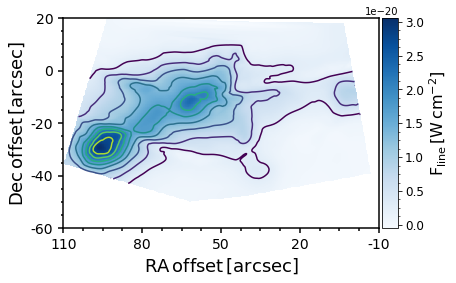

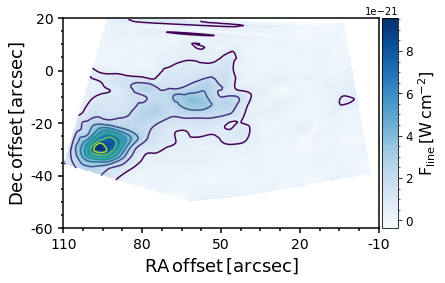

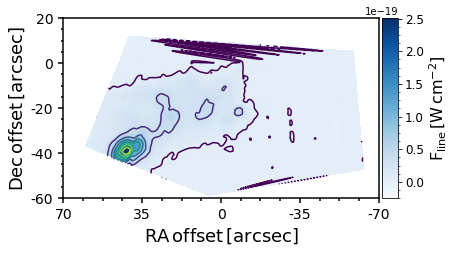

In [3]:
lines = ['FeII26', 'FeII24']
m = 'LH'
indir = '/Users/yaolun/test/ggd37_fitting/'
feii26 = CDF_contour('FeII26', 'GGD37', indir+m+'/ggd37_irs_'+m+'_lines.txt', pix_cen=1, cont=False, nofits=False, ggd37=True, offset=True, output=indir+m+'/FeII26.fits')
feii24 = CDF_contour('FeII24', 'GGD37', indir+m+'/ggd37_irs_'+m+'_lines.txt', pix_cen=1, cont=False, nofits=False, ggd37=True, offset=True, output=indir+m+'/FeII24.fits')
neii12 = CDF_contour('NeII12', 'GGD37', indir+'SH/ggd37_irs_SH_lines.txt', pix_cen=1, cont=False, nofits=False, ggd37=True, offset=True, output=indir+'SH/NeII12.fits')


In [4]:
feii24_26 = feii24[1][0]/feii26[1][0]
ra = feii26[0][0]
dec = feii26[0][1]
ra_neii = neii12[0][0]
dec_neii = neii12[0][1]

masked_ratio = np.ma.where((feii24_26 >= 0) & (feii24_26 < 20), feii24_26, 0).data

# masked_ratio = np.ma.array(feii26_24, mask=mask, fill_value=np.nan).filled()
# masked_ratio = masked_ratio.filled(fill_value=np.nan)

/Users/yaolun/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:7: RuntimeWarning: invalid value encountered in greater_equal
/Users/yaolun/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:7: RuntimeWarning: invalid value encountered in less


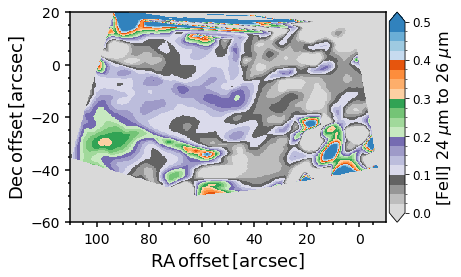

In [13]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

fig = plt.figure()
ax = fig.add_subplot(111)

# plot the contour with color and lines
levels = np.linspace(0, 0.5, 21)[1:]
# define the levels with the actual range in the data not the interpolated grid
# cs = ax.contour(ra, dec, masked_ratio, levels, linewidths=1.5, cmap='Accent')

# im = ax.imshow(feii26[1][0], cmap='Blues', origin='lower',
#                extent=[ra.max(), ra.min(), dec.min(), dec.max()])

ratio = ax.imshow(masked_ratio, cmap='tab20c_r', vmin=0, vmax=0.5,
               origin='lower', extent=[ra.max(), ra.min(), dec.min(), dec.max()])
# overplot = ax.contour(ra, dec, feii26[1][0])


# set the bad pixel to white
ratio.cmap.set_bad('w', 1.)
# setup ticks and tick labels
# ax.set_xticks(np.linspace(-np.ceil(-ra_range[1]/10)*10, np.ceil(ra_range[0]/10)*10, 5, dtype='int'))
# ax.set_xticklabels(np.linspace(-np.ceil(-ra_range[1]/10)*10, np.ceil(ra_range[0]/10)*10, 5, dtype='int'))
# ax.set_yticks(np.linspace(-np.ceil(-dec_range[1]/10)*10 , np.ceil(dec_range[0]/10)*10 , 5, dtype='int'))
# ax.set_yticklabels(np.linspace(-np.ceil(-dec_range[1]/10)*10, np.ceil(dec_range[0]/10)*10, 5, dtype='int'))

# create the colorbar
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
cb = fig.colorbar(ratio, cax=cax, extend='both')
# cb.solids.set_edgecolor("face")
cb.ax.minorticks_on()
cb.ax.set_ylabel(r'[FeII] 24 $\mu$m to 26 $\mu$m',fontsize=16)
cb_obj = plt.getp(cb.ax.axes, 'yticklabels')
plt.setp(cb_obj,fontsize=12)

# set the x, y labels
ax.set_xlabel(r'$\rm{RA\,offset\,[arcsec]}$', fontsize=18)
ax.set_ylabel(r'$\rm{Dec\,offset\,[arcsec]}$', fontsize=18)
[ax.spines[axis].set_linewidth(1.5) for axis in ['top','bottom','left','right']]
ax.minorticks_on()
ax.tick_params('both',labelsize=14,width=1.5,which='major',pad=5,length=5)
ax.tick_params('both',labelsize=14,width=1.5,which='minor',pad=5,length=2.5)
ax.set_aspect('equal', 'datalim')

# fig.savefig('/Users/yaolun/test/ggd37_fitting/FeII26to24.pdf', format='pdf', dpi=300, bbox_inches='tight')

TODO:
    * better reference coodinates, probably where [FeII] peaks at.
    * trim the image
    * use SNR cut